In [1]:
!pip install bert-for-tf2 >> /dev/null

In [2]:
#import sys
#print("User Current Version:-", sys.version)

In [3]:
#print(tf.__version__)

In [4]:
#print(np.__version__)

# Dataset

In [5]:
import pandas as pd

import os
import math
import datetime

from tqdm import tqdm

import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
from tensorflow.keras.callbacks import EarlyStopping


import seaborn as sns
from sklearn.model_selection import train_test_split
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

2022-07-04 23:18:50.764477: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-07-04 23:18:50.764734: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
df=pd.read_csv("cleaned-data.csv")

train=df.sample(frac=0.5).reset_index(drop=True)
test=df.sample(frac=0.2).reset_index(drop=True)

In [7]:
train.shape

(64372, 2)

In [8]:
print(len(train.Genres.unique().tolist()))

25


In [9]:
indexNames = []
for index, row in train.iterrows():
    if len(row.Genres.split("; "))>1:
        indexNames.append(index)
train = train.drop(indexNames)

In [10]:
train.shape

(46912, 2)

In [11]:
train.head()

,Lyric,Genres
1,i told a little lie baby you nade me cry thats...,Rock
2,after laughter comes tears after laughter come...,Pop
4,girl let me show you what you aint never seen ...,Hip Hop
5,you cant do everything at once but you can do ...,Rock
6,no sleep no sleep until im done with finding t...,Rock


/home/luisfgbs/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


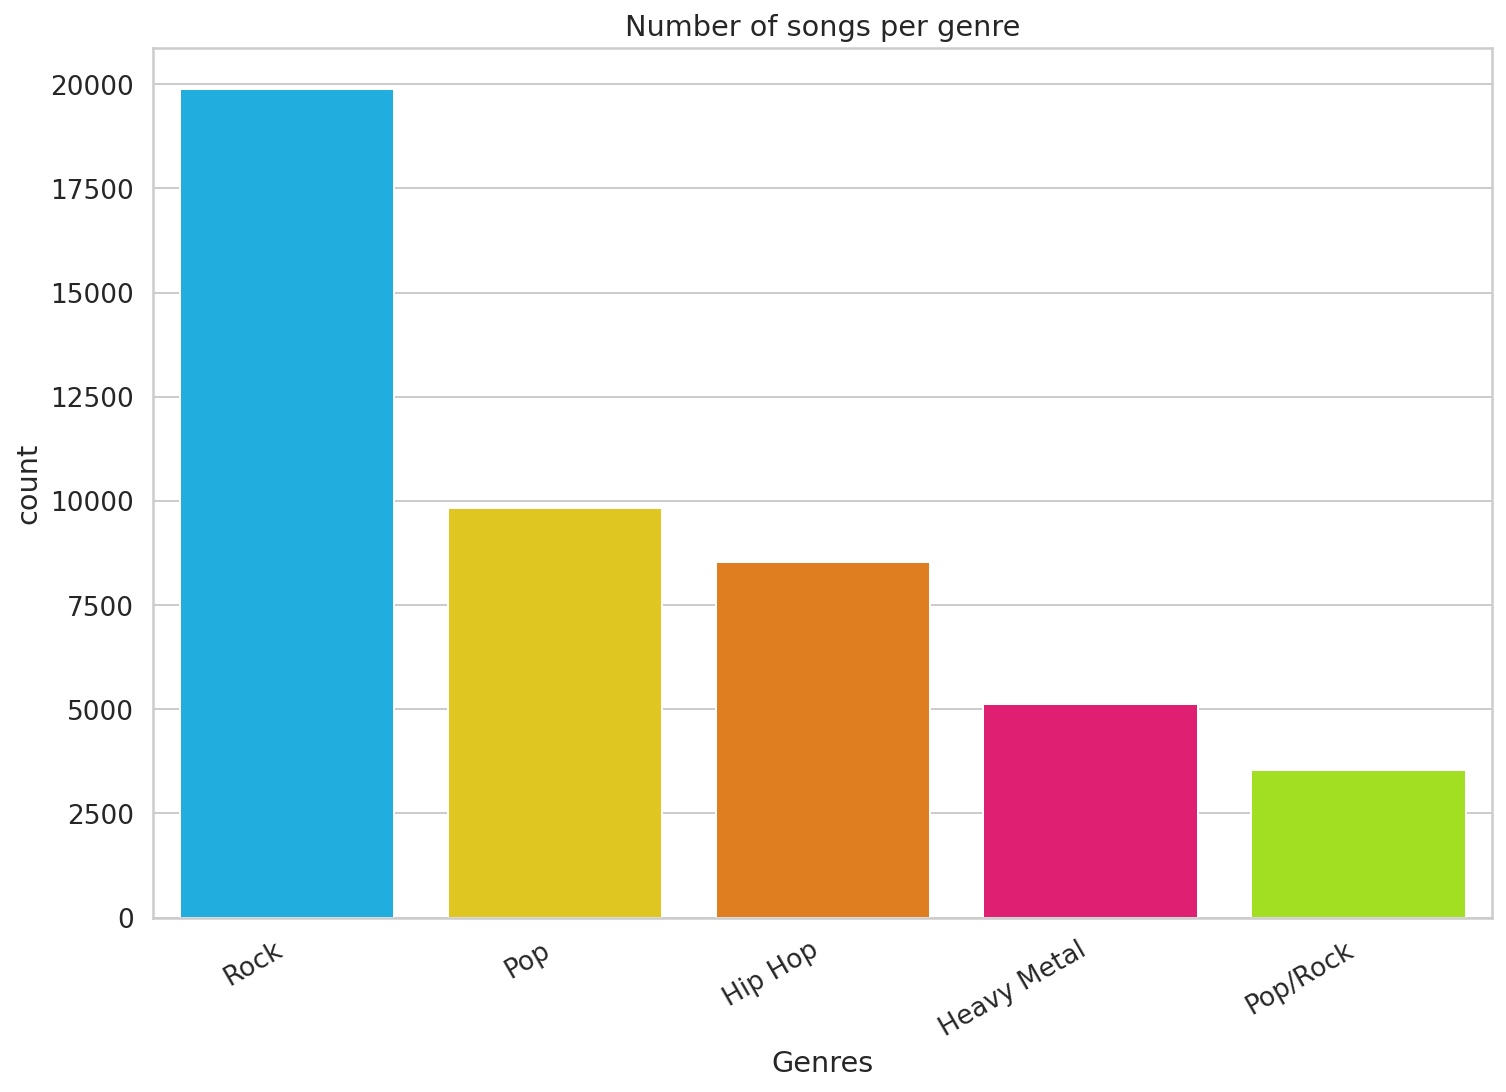

In [12]:
chart = sns.countplot(train.Genres, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of songs per genre")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Remover genres com menos de 2000 exemplos

In [13]:
for genre in train.Genres.unique().tolist():
    if len(train[train.Genres==genre])<2000:
        train.drop(train[train.Genres==genre].index.tolist(), inplace=True)

In [14]:
print(len(train.Genres.unique().tolist()))

5


/home/luisfgbs/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


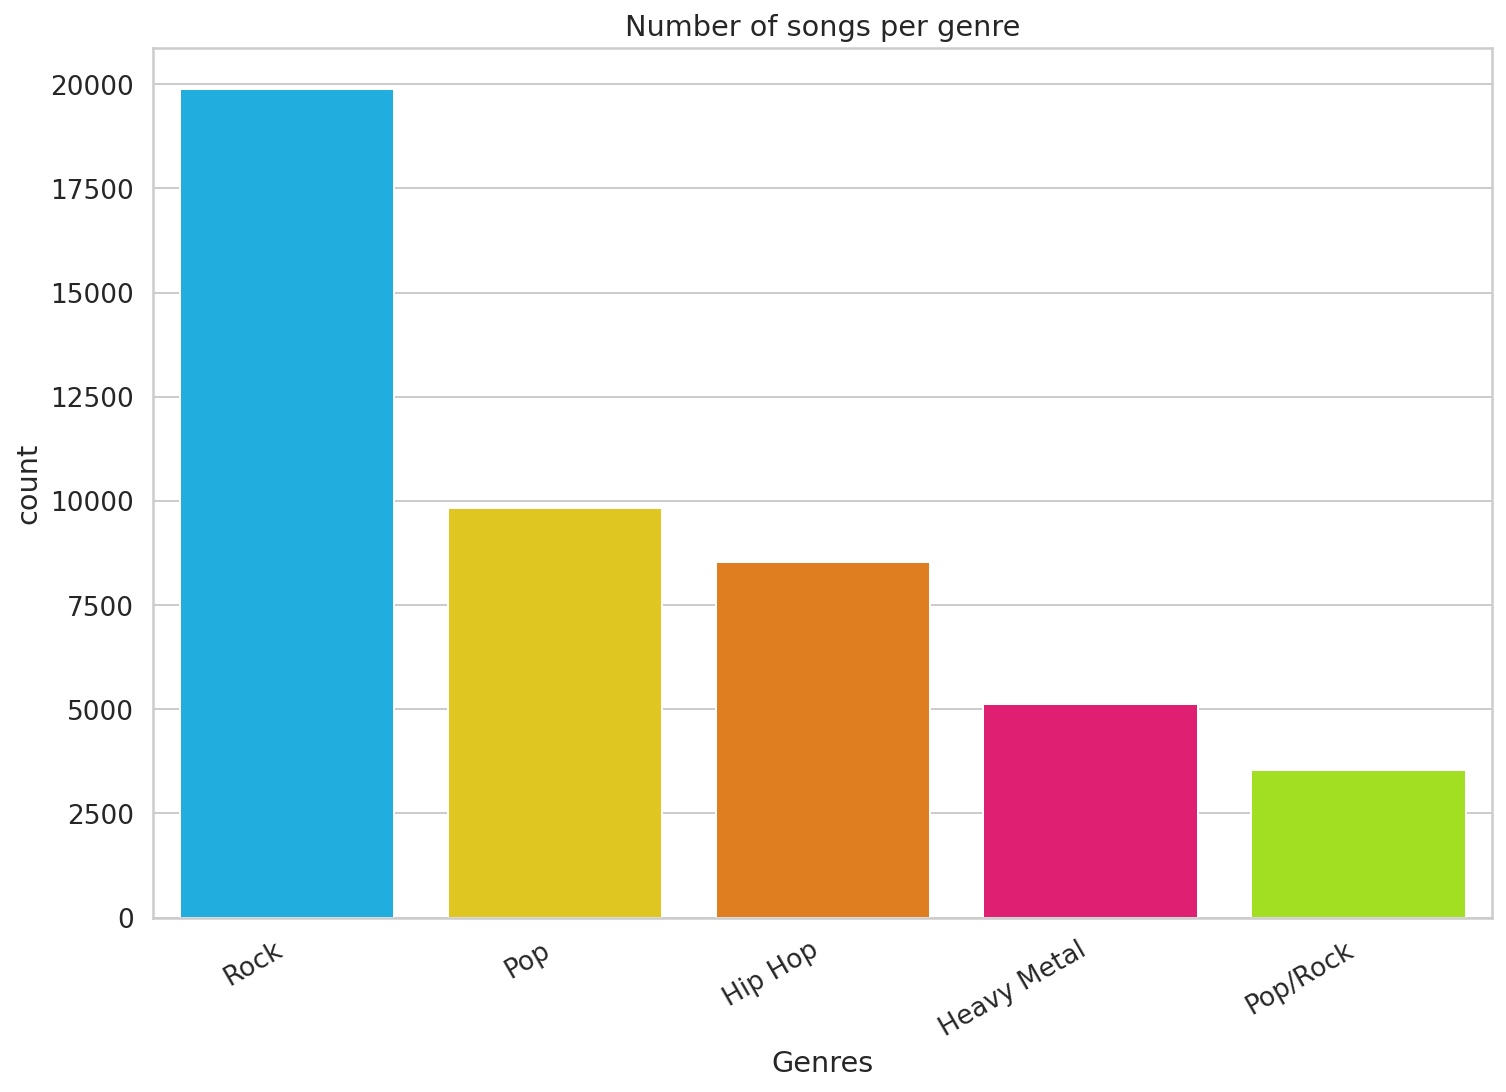

In [15]:
chart = sns.countplot(train.Genres, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of songs per genre")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Undersampling

In [16]:
genres_size=None

for genre in train.Genres.unique().tolist():
    if genres_size is not None:
        genres_size=min(genres_size, train[train.Genres==genre].shape[0])
    else:
        genres_size=train[train.Genres==genre].shape[0]
    
print(genres_size)

3540


In [17]:
print(train.shape)
for genre in train.Genres.unique().tolist():
    indexes=train[train.Genres==genre].index.tolist()
    num_to_drop=len(indexes)-genres_size
    indexes_to_drop=indexes[:-genres_size]
    #print(indexes_to_drop)
    train.drop(indexes_to_drop, inplace=True)
print(train.shape)

(46912, 2)
(17700, 2)


In [18]:
indexNames = []
for index, row in test.iterrows():
    if row.Genres not in train.Genres.unique().tolist():
        indexNames.append(index)
test = test.drop(indexNames)

/home/luisfgbs/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


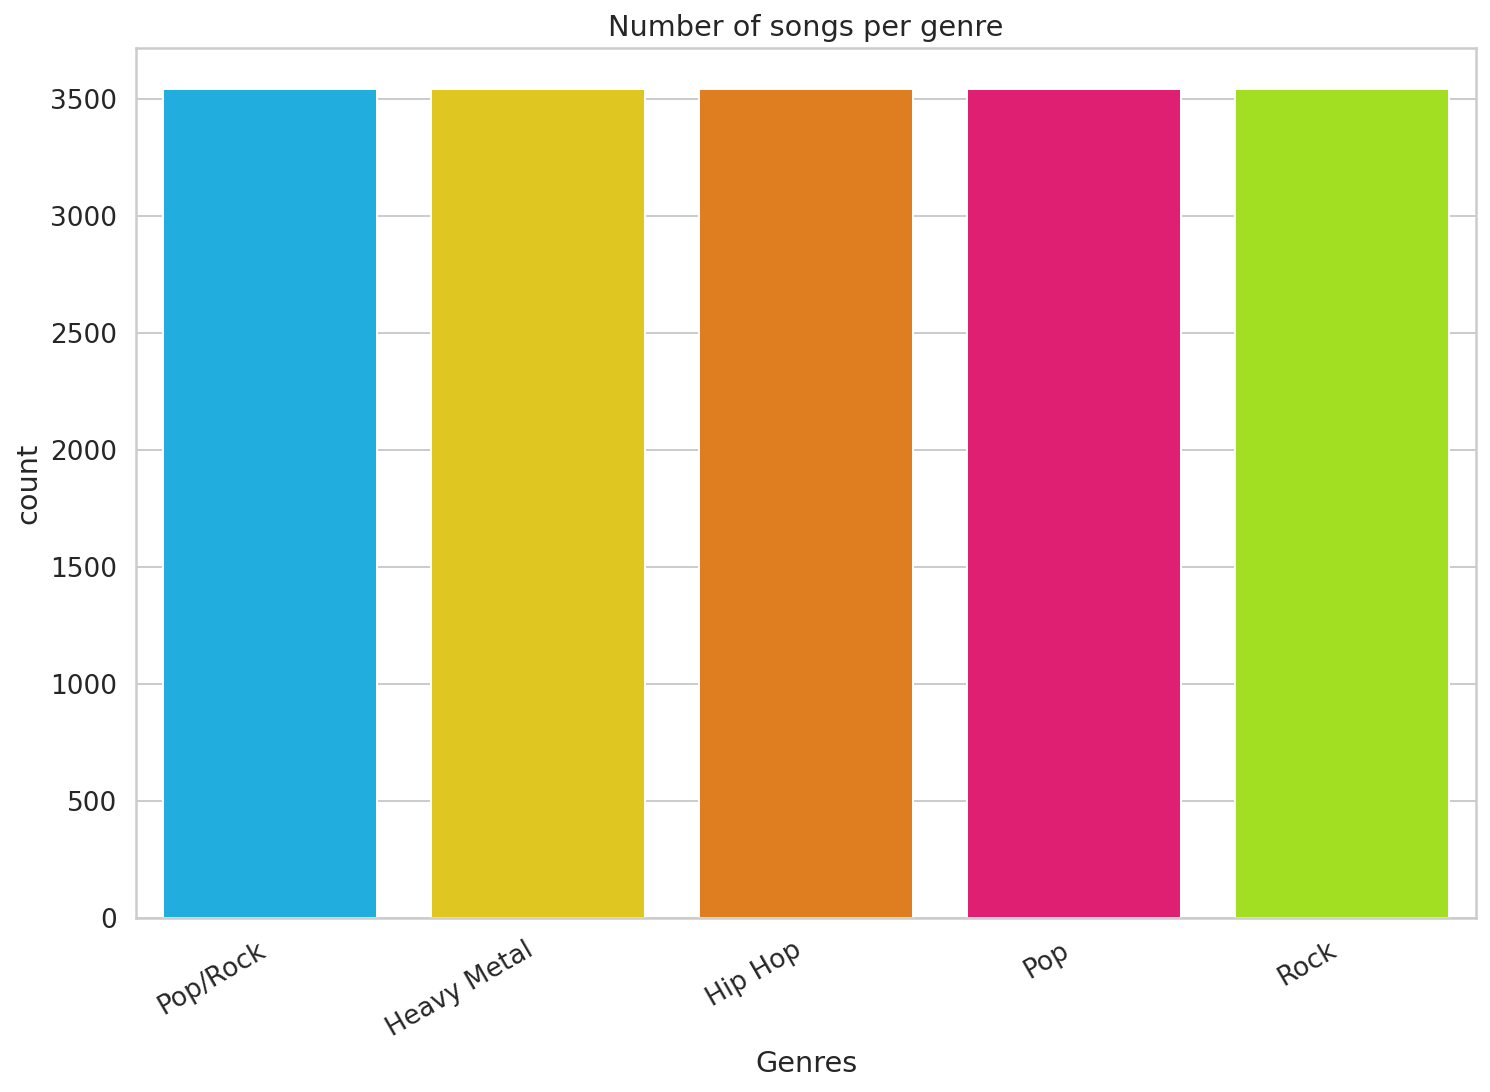

In [19]:
chart = sns.countplot(train.Genres, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of songs per genre")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Model

In [20]:
#!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

In [21]:
#!unzip uncased_L-12_H-768_A-12.zip

In [22]:
os.makedirs("model", exist_ok=True)

In [23]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [24]:
class IntentDetectionData:
  DATA_COLUMN = "Lyric"
  LABEL_COLUMN = "Genres"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [25]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

NotFoundError: model/uncased_L-12_H-768_A-12/vocab.txt; No such file or directory

In [ ]:
## tokenizer to transform text into tokens
#tokenizer = tf.keras.preprocessing.text.Tokenizer(
#    num_words=200000,
#    filters='!"#$%&()*+ ,-./:;<=>?@[\\]^_`{|}~\t\n',
#    lower=True, split=' ', char_level=False, oov_token=None,
#    #document_count=0, **kwargs
#)

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [ ]:
classes = train.Genres.unique().tolist()
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

In [ ]:
print(classes)

In [ ]:
print(bert_ckpt_file)

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

In [ ]:
model.summary()

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=10,
  callbacks=[tensorboard_callback, es]
)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir log

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');